# Data leakage

This lecture illustrates in more details some critical aspects of cross-validation. It is inspired by Chapter 7 of the book _Elements of Statistical Learning_ (Hastie, Tibshirani and Friedman, Springer).

We define a classification pipeline composed by 1) dimensionality reduction, and 2) cross-validation.
Dimensionality reduction is carried out by retaining only the features maximally correlated with the variable we want to predict. Afterwards, a classifier is trained and tested through 10 folds cross-validation.

We test the pipeline in a  particular setting: we generate 50 random data among two classes, by assigning random labels 0,1 to each sample. We also generate random features associated to each sample, normal distributed with dimension 5000.

The goal is to predict the random labels from the random features. 

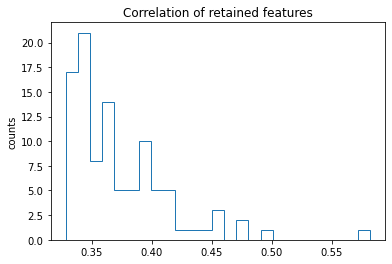

In [29]:
import numpy as np
import matplotlib.pyplot as plt

N = 50
N_features = 5000
features_to_retain = 100

def generate_data(N, N_features):
    # Generating N samples from two class labels 
    y = np.random.randint(2, size = N)

    # Creating fake data X associated to the variable y
    X = np.random.randn(N*N_features).reshape(N,N_features)

    return X, y
    

# Dimensionality reduction function
def reduce_data( X, y, features_to_retain):
    N_features = X.shape[1]
    # We compute the correlation between each feature and the target y
    correlation = np.array([np.abs(np.corrcoef(X[:,i],y)[0,1]) for i in range(N_features)])

    index_sorted = np.argsort(correlation)
    # We select only the features with highest correlation
    selected = index_sorted[-features_to_retain:]

    # The output is the data matrix with reduced dimensionality    
    reduced_X = X[:,selected]    
    
    return reduced_X, y, selected
    

# Data generation 
X_, y_ = generate_data( N, N_features)

# Dimensionality reduction 
X, y, _ = reduce_data( X_, y_, features_to_retain)

# Plotting the correlation between the remaining features and the outcome
correlation = np.array([np.abs(np.corrcoef(X[:,i],y)[0,1]) for i in range(features_to_retain)])
plt.hist(correlation, 25, histtype='step', label = 'population 2')
plt.title('Correlation of retained features')
plt.ylabel('counts')
plt.show()


**Exercise.** On this dataset, compute the 5-fold cross validated classification accuracy for a 2-nearest neighbours classifier.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 5)
kn =  KNeighborsClassifier(2)
cv_accuracy = []

for train_idx,test_idx in cv.split(X,y):
    kn.fit(X[train_idx],y[train_idx])
    cv_accuracy.append(kn.score(X[test_idx],y[test_idx]))
    print(cv_accuracy)
    
print('mean acc', np.mean(cv_accuracy))
print('std acc', np.std(cv_accuracy))

[1.0]
[1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
mean acc 1.0
std acc 0.0


What would be the expected accuracy of a classifier on this data? Since the data is random, we expect 50% chance of making a right guess, so we expect a testing error rate of 50% for any classifier. However, our cross validation accuracy is extremely high, almost 1. What is wrong in this example?

**Exercise.** Write a proper cross-validation approach.


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 5)
kn =  KNeighborsClassifier(2)
cv_accuracy_new = []

n_repeat = 5

for n in range(n_repeat):
    shuffle_indices = np.random.choice(N, N, replace = False)
    X_shuffle = X_[shuffle_indices,:]
    y_shuffle = y_[shuffle_indices]
    
    for train_idx,test_idx in cv.split(X_shuffle,y_shuffle):
        
        X_train = X_shuffle[train_idx]
        y_train = y_shuffle[train_idx]

        X_train_reduced, y_train_reduced, index_train = reduce_data(X_train, y_train, features_to_retain)
        kn.fit(X_train_reduced,y_train_reduced)

        X_test = X_shuffle[test_idx]
        y_test = y_shuffle[test_idx]

        X_test_reduced = X_test[:,index_train]  

        cv_accuracy_new.append(kn.score(X_test_reduced,y_test))
        #print(cv_accuracy_new)
    
print('mean acc', np.mean(cv_accuracy_new))
print('std acc', np.std(cv_accuracy_new))

mean acc 0.499959595959596
std acc 0.13334908997807143


# Cross-validation (II)

### In k-fold cross validation, what value should we choose for k?

The lesson is mainly based on Chapter 7 of _The Elements of Statistical Learning_ (Hastie, Tibshirani, Friedman, Springer). The code is also based on the very useful notes available at https://github.com/xavierbourretsicotte/Data-Portfolio.


Following the previous lecture on cross-validation, in this lesson we are going to analyse in depth the bias and variance in cross-validation strategies. The questionwe want to ask is, what is the relationship between the size of a fold in cross-validation, and the reliability of the assessment of the accuracy? 
Again, there are two important concepts that must be analysed:

- __bias:__ How much the average accuracy of the cross-validation differs from the expected one
- __variance__: How much the accuracy varies with the varying of the testing sets

To quantify these aspects we are going to use, again, a synthetic benchmark. We will test bias and variance in the setting of regression, although this example can be generalized in classification as well.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold

#Initializing noisy non linear data
n = 10000

# The data x is uniformly space in [0,1]
x = np.linspace(0,1,n)
x_plot = np.linspace(0,1,10*n)

# We add uniformly distributed noise. The variance of this variable is therefore var(noise) = 1/12
noise = np.random.uniform(-.5,.5, size = n)

# Generate the ground truth function y
y = np.sin(x * 1 * np.pi  - .5)  

# Generate noisy observations
y_noise = y + noise
Y = (y + noise).reshape(-1,1)
X = x.reshape(-1,1)


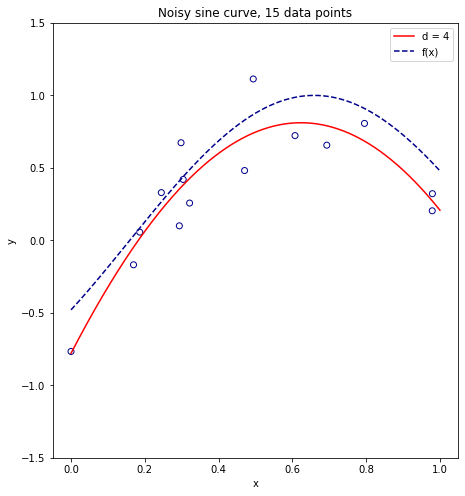

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

##Computing MSE for train size = 15 
# This instance of ShuffleSplit randomly samples from 15 indexes for training and 5 for testing 

train_size = 15
test_size = 5

samples_indices = np.random.choice(range(n), train_size + test_size)
training_index = samples_indices[:train_size]
testing_index = samples_indices[train_size:]
    
X_train, X_test, y_train, y_test = X[training_index],X[testing_index],Y[training_index], Y[testing_index]  
    
degs = np.arange(0,11)
degrees = [4]
Train_MSE_list, Test_MSE_list = [], []

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1)

# Computing training and testing error and plotting the prediction
for d in degs:
    poly = PolynomialFeatures(degree=d)
    model = LinearRegression()
    model.fit(poly.fit_transform(X_train),y_train)
    
    Train_MSE = mean_squared_error(y_train, model.predict(poly.fit_transform(X_train)))
    Test_MSE = mean_squared_error(y_test, model.predict(poly.fit_transform(X_test)))
    Train_MSE_list.append(Train_MSE)
    Test_MSE_list.append(Test_MSE)

    if d in degrees: 
        plt.plot(x_plot, model.predict(poly.fit_transform(x_plot.reshape(-1,1))), label = "d = " + str(d) , color = 'red') 


# Plot left hand side
ax.plot(x,y,color = 'darkblue',linestyle = '--', label = 'f(x)')
ax.scatter(X_train,y_train, facecolors = 'none', edgecolor = 'darkblue')
ax.set_title('Noisy sine curve, 15 data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.5,1.5)
ax.legend()
plt.show()



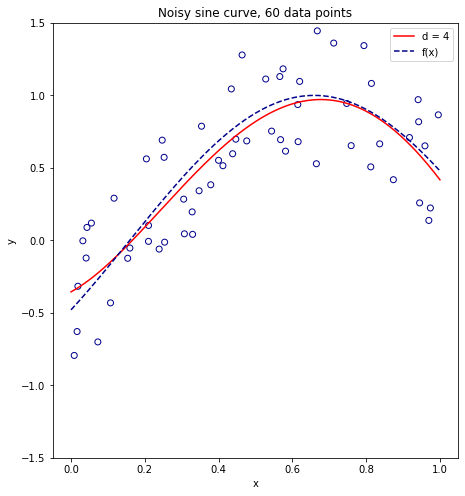

In [11]:
##Computing MSE for train size = 60
# This instance of ShuffleSplit randomly samples from 60 indexes for training and 15 for testing 

train_size = 60
test_size = 15

samples_indices = np.random.choice(range(n), train_size + test_size)
training_index = samples_indices[:train_size]
testing_index = samples_indices[train_size:]
    
X_train, X_test, y_train, y_test = X[training_index],X[testing_index],Y[training_index], Y[testing_index]  

degs = np.arange(0,11)
degrees = [4]


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 2)

# Computing training and testing error and plotting the prediction
for d in degs:
    poly = PolynomialFeatures(degree=d)
    model = LinearRegression()
    model.fit(poly.fit_transform(X_train),y_train)
    
    Train_MSE = mean_squared_error(y_train, model.predict(poly.fit_transform(X_train)))
    Test_MSE = mean_squared_error(y_test, model.predict(poly.fit_transform(X_test)))
    Train_MSE_list.append(Train_MSE)
    Test_MSE_list.append(Test_MSE)

    if d in degrees: 
        plt.plot(x_plot, model.predict(poly.fit_transform(x_plot.reshape(-1,1))), label = "d = " + str(d) , color = 'red') 


# Plot right hand side
ax.plot(x,y,color = 'darkblue',linestyle = '--', label = 'f(x)')
ax.scatter(X_train,y_train, facecolors = 'none', edgecolor = 'darkblue')
ax.set_title('Noisy sine curve, 60 data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.5,1.5)
ax.legend()

plt.show()


We generated our ground truth, and we can sample noisy observations from it. 
Since the noise is sampled from a uniform distribution, $\epsilon\sim\mathbf{U}[-0.5,0.5]$, the variance of the data is $Var(\epsilon) = \frac{1}{12}$. Therefore, the minimum squared error of a regression model can be $MSE = \frac{1}{12}$ (remember: Bias-Variance-Noise decomposition). 

**Exercise.** Write a cross-validation routine to answer the following questions:
- Is k-fold cross validation able to correctly quantify the accuracy? 
- How does the quantification depend on the training size? 
- How does it depend on the fold size k?

In [12]:
## Computing cross-validation error for different training data size

CV_Mean_MSE, CV_Std_MSE = [],[]

# Defining training/testing pairs, each time with ratio = 5
train_sizes=np.array([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
test_sizes = np.array([1,2,3,4,5,6,7,8,10,12,14,16,18,20])

# For each training size compute cross-validated errors among 300 repeats
# store and compare mean and standard deviation for each training size




In [14]:
#Plotting


From *The Elements of Statistical Learning*:

*The figure shows a hypothetical “learning curve” for a classifier on a given task, a plot of 1 − Err versus the size of the training set N. The performance of the classifier improves as the training set size increases to 100 observations; increasing the number further to 100 brings only a small benefit. If our training set had 100 observations, five fold cross-validation would estimate the performance of our classifier over training sets of size 80, which from the figure is virtually the same as the performance for training set size 100. Thus cross-validation would not suffer from much bias. However if the training set had 40 observations, five fold cross-validation would estimate the performance of our classifier over training sets of size 32, and from the figure that would be an underestimate of 1 − Err. Hence as an estimate of Err, cross-validation would be biased upward.*

## k-fold cross validation on small data sets

In [15]:
## 40 Data points only
## Computing cross-validation error for different k-fold and leave-k-out strategies

CV_Mean_MSE_small, CV_Var_MSE_small = [], []

k_folds_range = np.array([2,4,6,8,10,15,20,25,29,35,39])

for k in k_folds_range:
    #Reset list at start of loop
    i_Mean_MSE = []
    
    #Repeat experiment i times
    for i in range(300):
        #Reset list at start of loop        
        Kfold_MSE_list = []
        # Sample from original dataset
        shuffled_indices = np.random.choice(len(Y), 40, replace = False)
        X_shuffled, Y_shuffled = X[shuffled_indices,:], Y[shuffled_indices]
        #Loop over kfold splits
        kf = KFold(n_splits = k, shuffle=True)
        for train_index, test_index in kf.split(X_shuffled):
            X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
            y_train, y_test = Y_shuffled[train_index], Y_shuffled[test_index]

            #Fit model on X_train
            poly = PolynomialFeatures(degree=4)
            model = LinearRegression()
            model.fit(poly.fit_transform(X_train),y_train)
            
            #Store each Kfold MSE values on X_test
            Kfold_MSE_list.append(mean_squared_error(y_test, model.predict(poly.fit_transform(X_test))))
            
        #Average over the K folds for a single "i" iteration
        i_Mean_MSE.append(np.mean(Kfold_MSE_list))
    
    #Average and std for a particular k value over all i iterations
    CV_Mean_MSE_small.append(np.mean(i_Mean_MSE))
    CV_Var_MSE_small.append(np.var(i_Mean_MSE, ddof = 1))


#Convert to numpy for convenience
CV_Mean_MSE_small  = np.asarray(CV_Mean_MSE_small)
CV_Var_MSE_small  = np.asarray(CV_Var_MSE_small)
CV_Std_MSE_small = np.sqrt(CV_Var_MSE_small)


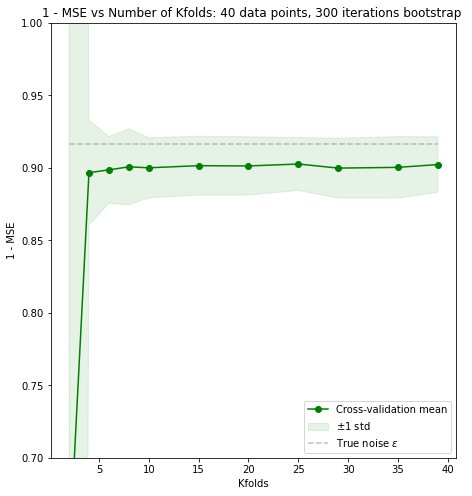

In [17]:
#Plotting result - LHS - 1 - MSE
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1, 2, 1)

plt.fill_between(k_folds_range, 1 - (CV_Mean_MSE_small - CV_Std_MSE_small),
                 1 - (CV_Mean_MSE_small + CV_Std_MSE_small), alpha=0.1, color="g", label = '$\pm 1$ std')

plt.plot(k_folds_range, 1 - CV_Mean_MSE_small, 'o-', color="g",
         label="Cross-validation mean")

plt.hlines(1 - 1.0/12 , min(k_folds_range),max(k_folds_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="lower right"), 
plt.ylim(0.7,1)
plt.ylabel('1 - MSE'), plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 40 data points, 300 iterations bootstrap ')

plt.show()

In [18]:
pd.DataFrame(data = {'K = ':k_folds_range,'Mean MSE': CV_Mean_MSE_small,'Std MSE': CV_Std_MSE_small })

,K =,Mean MSE,Std MSE
0,2,0.371709,3.120774
1,4,0.103285,0.036211
2,6,0.101385,0.023073
3,8,0.099283,0.026212
4,10,0.099937,0.020743
5,15,0.098484,0.020311
6,20,0.098664,0.020109
7,25,0.097332,0.018240
8,29,0.100150,0.020639
9,35,0.099637,0.021197


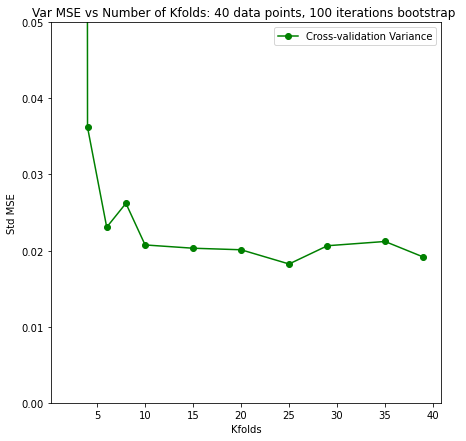

In [19]:
plt.figure(figsize = (7,7))

plt.plot(k_folds_range, CV_Std_MSE_small, 'o-', color="g",
         label="Cross-validation Variance")

plt.legend(loc="best")
plt.ylabel('Std MSE')
plt.xlabel('Kfolds')
plt.ylim(0,0.05)
plt.title('Var MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')
plt.show()

## k-fold cross validation on large data sets

**Exercise.** Repeat the exercise above, this time by using with 200 data points.

### Repeating the exercise above with a different strategy

In [26]:
## 40 Data points 
## Computing cross-validation error for different k-fold and leave-k-out strategies
## This time the training data is fixed, but cv is performed on permuted data rows

CV_Mean_MSE_small, CV_Var_MSE_small = [],[]
k_folds_range = np.array([2,4,6,8,10,15,20,25,29,35,39])

#Sample from original dataset
shuffled_indices = np.random.choice(len(Y), 40, replace = False)
X_subset, Y_subset = X[shuffled_indices,:], Y[shuffled_indices]  

for k in k_folds_range:
    #Reset list at start of loop
    i_Mean_MSE = []
    
    #Repeat experiment i times
    for i in range(300):
        #Reset list at start of loop        
        Kfold_MSE_list = []
        
        #Loop over kfold splits
        kf = KFold(n_splits = k, shuffle = True)
        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            #Fit model on X_train
            poly = PolynomialFeatures(degree=4)
            model = LinearRegression()
            model.fit(poly.fit_transform(X_train),y_train)
            
            #Store each Kfold MSE values on X_test
            Kfold_MSE_list.append(mean_squared_error(y_test, model.predict(poly.fit_transform(X_test))))
            
        #Average over the K folds for a single "i" iteration
        i_Mean_MSE.append(np.mean(Kfold_MSE_list))
    
    #Average and std for a particular k value over all i iterations
    CV_Mean_MSE_small.append(np.mean(i_Mean_MSE))
    CV_Var_MSE_small.append(np.var(i_Mean_MSE, ddof = 1))
    
#Convert to numpy for convenience
CV_Mean_MSE_small  = np.asarray(CV_Mean_MSE_small)
CV_Var_MSE_small  = np.asarray(CV_Var_MSE_small)
CV_Std_MSE_small = np.sqrt(CV_Var_MSE_small)

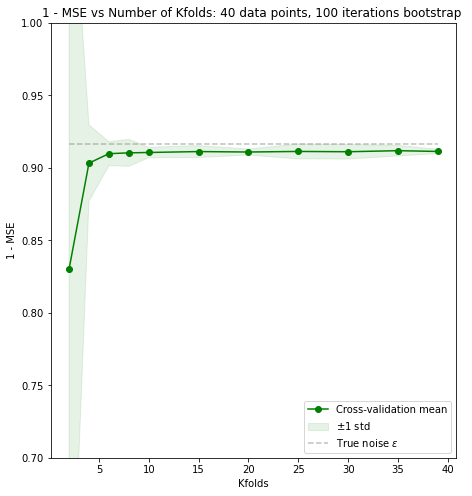

In [27]:
#Plotting result - LHS - 1 - MSE
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1, 2, 1)
k_folds_range = np.array([2,4,6,8,10,15,20,25,30,35,39])

plt.fill_between(k_folds_range, 1 - (CV_Mean_MSE_small - CV_Std_MSE_small),
                 1 - (CV_Mean_MSE_small + CV_Std_MSE_small), alpha=0.1, color="g", label = '$\pm 1$ std')

plt.plot(k_folds_range, 1 - CV_Mean_MSE_small, 'o-', color="g",
         label="Cross-validation mean")

plt.hlines(1 - 1.0/12 , min(k_folds_range),max(k_folds_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="lower right"), 
plt.ylim(0.7,1)
plt.ylabel('1 - MSE'), plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')
plt.show()

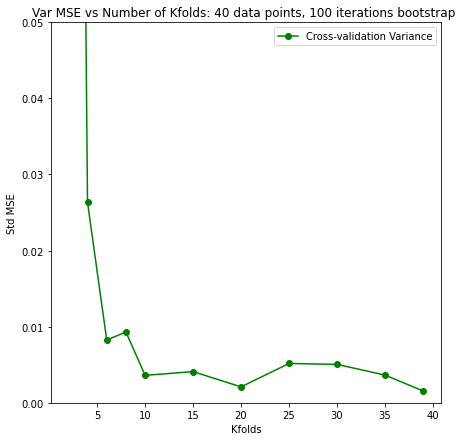

In [28]:
plt.figure(figsize = (7,7))

plt.plot(k_folds_range, CV_Std_MSE_small, 'o-', color="g",
         label="Cross-validation Variance")

plt.legend(loc="best")
plt.ylabel('Std MSE')
plt.xlabel('Kfolds')
plt.ylim(0,.05)
plt.title('Var MSE vs Number of Kfolds: 40 data points, 100 iterations bootstrap ')
plt.show()

**Exercise.** Repeat the exercise above, this time by using with 200 data points.